# Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import pylab
import seaborn as sns
import gc
from scipy.stats import boxcox

# Load Data

In [2]:
cols = ["Severity","Start_Time","Start_Lat","Start_Lng","Distance(mi)","State","Timezone","Temperature(F)","Wind_Chill(F)","Humidity(%)","Pressure(in)","Visibility(mi)","Wind_Direction","Wind_Speed(mph)","Precipitation(in)","Weather_Condition","Amenity","Bump","Crossing","Give_Way","Junction","No_Exit","Railway","Roundabout","Station","Stop","Traffic_Calming","Traffic_Signal","Turning_Loop","Sunrise_Sunset","Civil_Twilight","Nautical_Twilight","Astronomical_Twilight"]
data = pd.read_csv('data/US_Accidents_March23.csv', usecols=cols)
print("The shape of data is:",(data.shape))
display(data.head(3))

The shape of data is: (7728394, 33)


,Severity,Start_Time,Start_Lat,Start_Lng,Distance(mi),State,Timezone,Temperature(F),Wind_Chill(F),Humidity(%),...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,3,2016-02-08 05:46:00,39.865147,-84.058723,0.01,OH,US/Eastern,36.9,NaN,91.0,...,False,False,False,False,False,False,Night,Night,Night,Night
1,2,2016-02-08 06:07:59,39.928059,-82.831184,0.01,OH,US/Eastern,37.9,NaN,100.0,...,False,False,False,False,False,False,Night,Night,Night,Day
2,2,2016-02-08 06:49:27,39.063148,-84.032608,0.01,OH,US/Eastern,36.0,33.3,100.0,...,False,False,False,False,True,False,Night,Night,Day,Day


# Preprocessing

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7728394 entries, 0 to 7728393
Data columns (total 33 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Severity               int64  
 1   Start_Time             object 
 2   Start_Lat              float64
 3   Start_Lng              float64
 4   Distance(mi)           float64
 5   State                  object 
 6   Timezone               object 
 7   Temperature(F)         float64
 8   Wind_Chill(F)          float64
 9   Humidity(%)            float64
 10  Pressure(in)           float64
 11  Visibility(mi)         float64
 12  Wind_Direction         object 
 13  Wind_Speed(mph)        float64
 14  Precipitation(in)      float64
 15  Weather_Condition      object 
 16  Amenity                bool   
 17  Bump                   bool   
 18  Crossing               bool   
 19  Give_Way               bool   
 20  Junction               bool   
 21  No_Exit                bool   
 22  Railway           

In [4]:
# fix datetime type
data['Start_Time'] = pd.to_datetime(data['Start_Time'],format="ISO8601")


data['Year'] = data['Start_Time'].dt.year
data['Month'] = data['Start_Time'].dt.month
data['Day'] = data['Start_Time'].dt.day
data['Hour'] = data['Start_Time'].dt.hour
data['Week'] = data['Start_Time'].dt.weekday

data.drop(['Start_Time'], axis=1, inplace=True)

In [5]:
missing = pd.DataFrame(data.isnull().sum()).reset_index()
missing.columns = ['Feature', 'Missing_Percent(%)']
missing['Missing_Percent(%)'] = missing['Missing_Percent(%)'].apply(lambda x: x / data.shape[0] * 100)
missing.loc[missing['Missing_Percent(%)']>0,:]

,Feature,Missing_Percent(%)
5,Timezone,0.101030
6,Temperature(F),2.120143
7,Wind_Chill(F),25.865904
8,Humidity(%),2.253301
9,Pressure(in),1.820288
10,Visibility(mi),2.291524
11,Wind_Direction,2.267043
12,Wind_Speed(mph),7.391355
13,Precipitation(in),28.512858
14,Weather_Condition,2.244438


In [6]:
data = data.dropna(subset=['Wind_Direction','Visibility(mi)','Pressure(in)','Humidity(%)',"Civil_Twilight","Nautical_Twilight","Astronomical_Twilight",
                       'Sunrise_Sunset','Weather_Condition'])

Text(0.5, 0.98, 'Analyzing distribution')

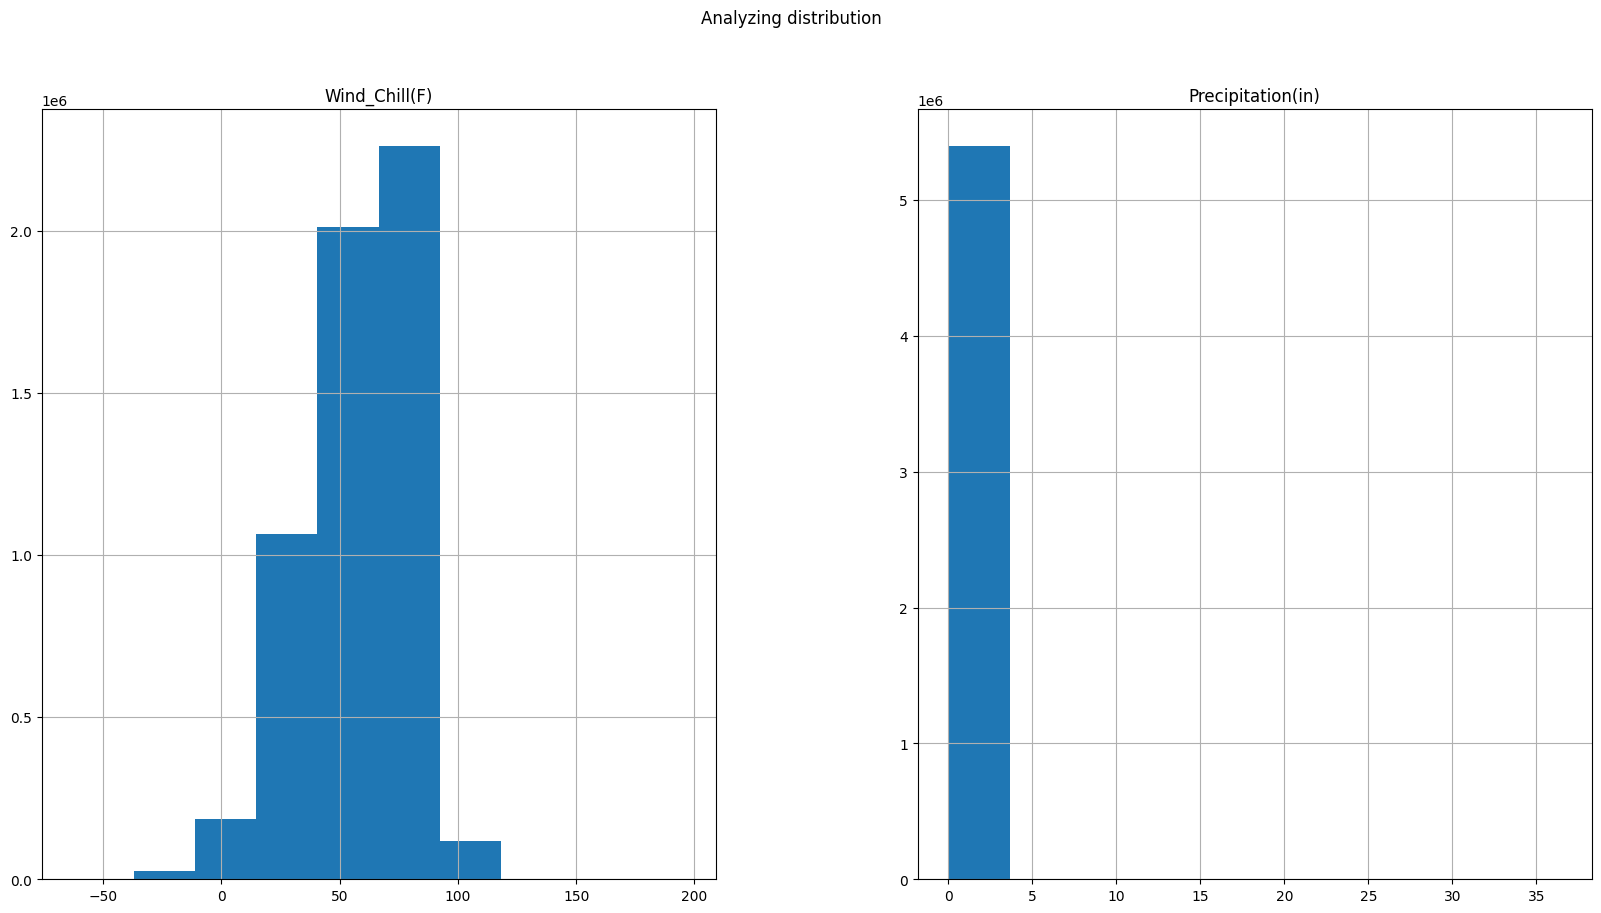

In [7]:
data.hist(
    column=['Wind_Chill(F)', 'Precipitation(in)'],
    figsize=(20, 10)
)
pylab.suptitle("Analyzing distribution", fontsize="large")

In [8]:
data = data.drop(['Precipitation(in)'], axis=1)

In [9]:
data = data.dropna(subset=['Wind_Chill(F)'])

In [10]:
missing = pd.DataFrame(data.isnull().sum()).reset_index()
missing.columns = ['Feature', 'Missing_Percent(%)']
missing['Missing_Percent(%)'] = missing['Missing_Percent(%)'].apply(lambda x: x / data.shape[0] * 100)
missing.loc[missing['Missing_Percent(%)']>0,:]

,Feature,Missing_Percent(%)


In [11]:
print("The shape of data is:",(data.shape))

The shape of data is: (5667054, 36)


In [12]:
print("Wind Direction: ", data['Wind_Direction'].unique())

Wind Direction:  ['SW' 'SSW' 'WSW' 'WNW' 'NW' 'West' 'NNW' 'NNE' 'South' 'Variable' 'North'
 'SE' 'SSE' 'ESE' 'East' 'NE' 'ENE' 'E' 'W' 'S' 'VAR' 'CALM' 'N']


<Axes: xlabel='Wind_Direction'>

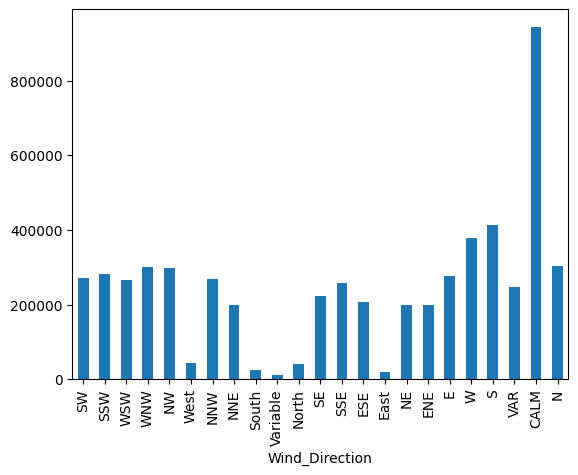

In [13]:
pd.Series(data['Wind_Direction']).value_counts(sort=False).plot(kind='bar')

In [14]:
data.loc[data['Wind_Direction']=='Calm','Wind_Direction'] = 'CALM'
data.loc[(data['Wind_Direction']=='West')|(data['Wind_Direction']=='WSW')|(data['Wind_Direction']=='WNW'),'Wind_Direction'] = 'W'
data.loc[(data['Wind_Direction']=='South')|(data['Wind_Direction']=='SSW')|(data['Wind_Direction']=='SSE'),'Wind_Direction'] = 'S'
data.loc[(data['Wind_Direction']=='North')|(data['Wind_Direction']=='NNW')|(data['Wind_Direction']=='NNE'),'Wind_Direction'] = 'N'
data.loc[(data['Wind_Direction']=='East')|(data['Wind_Direction']=='ESE')|(data['Wind_Direction']=='ENE'),'Wind_Direction'] = 'E'
data = data[(data["Wind_Direction"].str.contains('VAR') |data["Wind_Direction"].str.contains('Variable'))== False]
print("Wind Direction after simplification: ", data['Wind_Direction'].unique())

Wind Direction after simplification:  ['SW' 'S' 'W' 'NW' 'N' 'SE' 'E' 'NE' 'CALM']


In [15]:
weather ='!'.join(data['Weather_Condition'].dropna().unique().tolist())
weather = np.unique(np.array(re.split(
    "!|\s/\s|\sand\s|\swith\s|Partly\s|Mostly\s|Blowing\s|Freezing\s", weather))).tolist()
print("Weather Conditions: ", weather)

<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
C:\Users\THANH TAN\AppData\Local\Temp\ipykernel_6508\253030921.py:3: SyntaxWarning: invalid escape sequence '\s'
  "!|\s/\s|\sand\s|\swith\s|Partly\s|Mostly\s|Blowing\s|Freezing\s", weather))).tolist()


Weather Conditions:  ['', 'Clear', 'Cloudy', 'Drifting Snow', 'Drizzle', 'Dust', 'Dust Whirls Nearby', 'Dust Whirlwinds', 'Fair', 'Fog', 'Funnel Cloud', 'Hail', 'Haze', 'Heavy ', 'Heavy Drizzle', 'Heavy Ice Pellets', 'Heavy Rain', 'Heavy Rain Shower', 'Heavy Sleet', 'Heavy Snow', 'Heavy T-Storm', 'Heavy Thunderstorms', 'Ice Pellets', 'Light ', 'Light Drizzle', 'Light Fog', 'Light Hail', 'Light Ice Pellets', 'Light Rain', 'Light Rain Shower', 'Light Rain Showers', 'Light Sleet', 'Light Snow', 'Light Snow Grains', 'Light Snow Shower', 'Light Snow Showers', 'Light Thunderstorms', 'Low Drifting Snow', 'Mist', 'N/A Precipitation', 'Overcast', 'Partial Fog', 'Patches of Fog', 'Rain', 'Rain Shower', 'Rain Showers', 'Sand', 'Scattered Clouds', 'Shallow Fog', 'Showers in the Vicinity', 'Sleet', 'Small Hail', 'Smoke', 'Snow', 'Snow Grains', 'Snow Nearby', 'Snow Showers', 'Squalls', 'T-Storm', 'Thunder', 'Thunder in the Vicinity', 'Thunderstorm', 'Thunderstorms', 'Tornado', 'Widespread Dust', 'Wi

In [16]:
data.loc[(data['Weather_Condition'].str.contains('Clear')|data['Weather_Condition'].str.contains('Fair')),'Weather_Condition']='Clear'
data.loc[(data['Weather_Condition'].str.contains('Cloud')|data['Weather_Condition'].str.contains('Overcast')),'Weather_Condition']='Cloud'
data.loc[(data['Weather_Condition'].str.contains('Rain')|data['Weather_Condition'].str.contains('Drizzle')|data['Weather_Condition'].str.contains('Showers in the Vicinity')),'Weather_Condition']='Rain'
data.loc[(data['Weather_Condition'].str.contains('Dust')|data['Weather_Condition'].str.contains('Smoke')|data['Weather_Condition'].str.contains('Sand')|data['Weather_Condition'].str.contains('Ash')),'Weather_Condition']='Dust'
data.loc[(data['Weather_Condition'].str.contains('Heavy Rain')|data['Weather_Condition'].str.contains('Rain Shower')|data['Weather_Condition'].str.contains('T-Storm')|data['Weather_Condition'].str.contains('Thunder')|data['Weather_Condition'].str.contains('Tornado')),'Weather_Condition']='Heavy_Rain'
data.loc[(data['Weather_Condition'].str.contains('Hail')|data['Weather_Condition'].str.contains('Snow')|data['Weather_Condition'].str.contains('Sleet')|data['Weather_Condition'].str.contains('Wintry')|data['Weather_Condition'].str.contains('Ice')),'Weather_Condition']='Snow'
data.loc[(data['Weather_Condition'].str.contains('Heavy Snow')|data['Weather_Condition'].str.contains('Heavy Sleet')|data['Weather_Condition'].str.contains('Heavy Ice Pellets')|data['Weather_Condition'].str.contains('Snow Showers')|data['Weather_Condition'].str.contains('Squalls')|data['Weather_Condition'].str.contains('Wintry')),'Weather_Condition']='Heavy_Snow'
data.loc[(data['Weather_Condition'].str.contains('Fog')|data['Weather_Condition'].str.contains('Mist')|data['Weather_Condition'].str.contains('Haze')),'Weather_Condition']='Fog'
#More to do here

data = data[data['Weather_Condition'] != ""]
data = data[data['Weather_Condition'] != "N/A Precipitation"]

weather ='!'.join(data['Weather_Condition'].dropna().unique().tolist())
weather = np.unique(np.array(re.split(
    "!|\s/\s|\sand\s|\swith\s|Partly\s|Mostly\s|Blowing\s|Freezing\s", weather))).tolist()
print("Weather Conditions: ", weather)


<>:16: SyntaxWarning: invalid escape sequence '\s'
<>:16: SyntaxWarning: invalid escape sequence '\s'
C:\Users\THANH TAN\AppData\Local\Temp\ipykernel_6508\1063879987.py:16: SyntaxWarning: invalid escape sequence '\s'
  "!|\s/\s|\sand\s|\swith\s|Partly\s|Mostly\s|Blowing\s|Freezing\s", weather))).tolist()


Weather Conditions:  ['Clear', 'Cloud', 'Dust', 'Fog', 'Heavy_Rain', 'Heavy_Snow', 'Rain', 'Snow']


# Insights

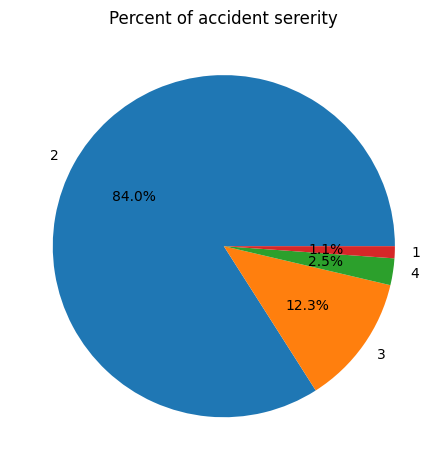

In [17]:
s = data['Severity'].value_counts()
plt.pie(s,labels = s.index,
        autopct='%1.1f%%',
        startangle=0)
plt.title("Percent of accident sererity")
plt.tight_layout()
plt.show()

In [18]:
data.Severity.value_counts()
data.loc[(data['Severity'] <= 2), 'Severity'] = 0
data.loc[(data['Severity'] >= 3), 'Severity'] = 1

data.Severity.value_counts()

Severity
0    4603657
1     802045
Name: count, dtype: int64

In [19]:
def resampleData(df,col,n=10000):
  return pd.concat([df[df[col]==1].sample(n, replace = True),
                   df[df[col]==0].sample(n)], axis=0)

In [20]:
re_df = resampleData(data,'Severity',1000000)
print("Resample Data: ",re_df.Severity.value_counts())

Resample Data:  Severity
1    1000000
0    1000000
Name: count, dtype: int64


Let's Explore the data

## Time Feature

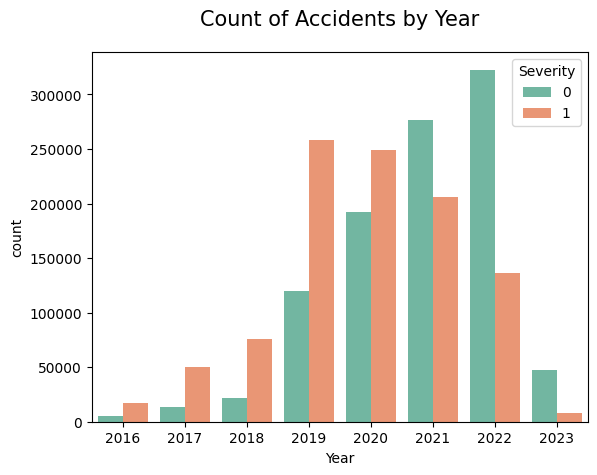

In [21]:
sns.countplot(x='Year', hue='Severity', data= re_df,palette="Set2")
plt.title('Count of Accidents by Year', size=15, y=1.05)
plt.show()

In [22]:
data = data.loc[data['Year'] >= 2019]
data['Severity'].value_counts()

re_df = resampleData(data,'Severity',800000)

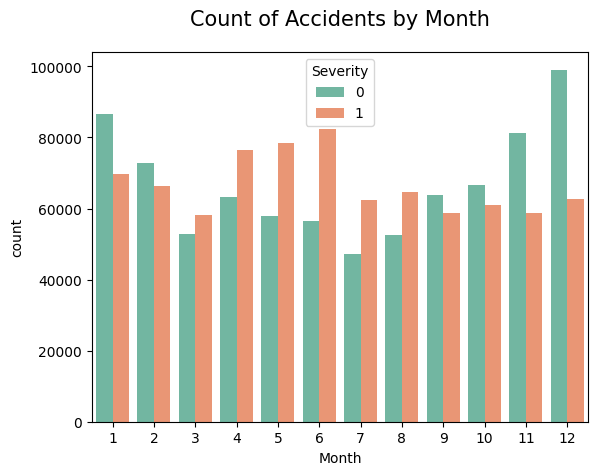

In [23]:
sns.countplot(x='Month', hue='Severity', data = re_df,palette="Set2")
plt.title('Count of Accidents by Month', size=15, y=1.05)
plt.show()

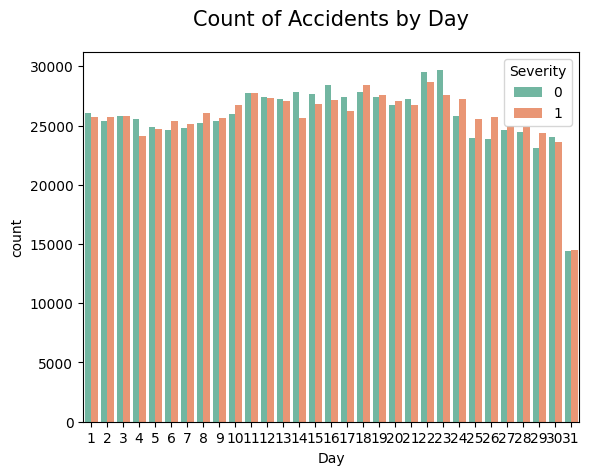

In [24]:
sns.countplot(x='Day', hue='Severity', data= re_df,palette="Set2")
plt.title('Count of Accidents by Day', size=15, y=1.05)
plt.show()

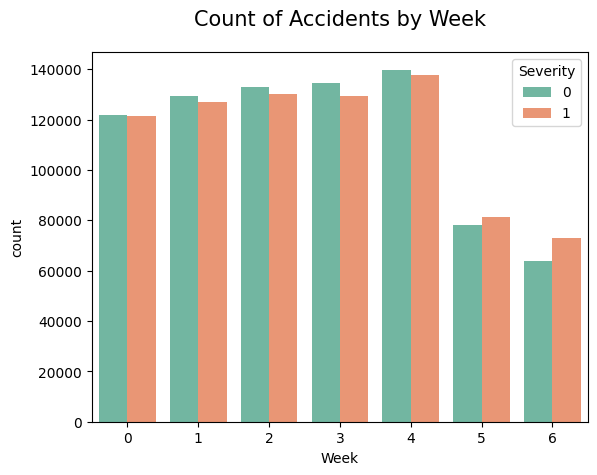

In [25]:
sns.countplot(x='Week', hue='Severity', data= re_df,palette="Set2")
plt.title('Count of Accidents by Week', size=15, y=1.05)
plt.show()

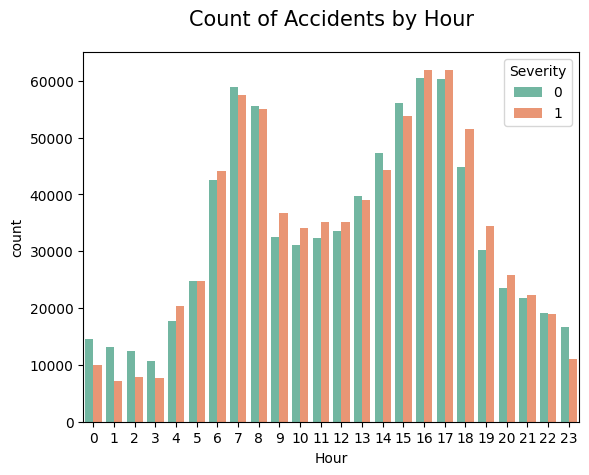

In [26]:
sns.countplot(x='Hour', hue='Severity', data= re_df,palette="Set2")
plt.title('Count of Accidents by Hour', size=15, y=1.05)
plt.show()

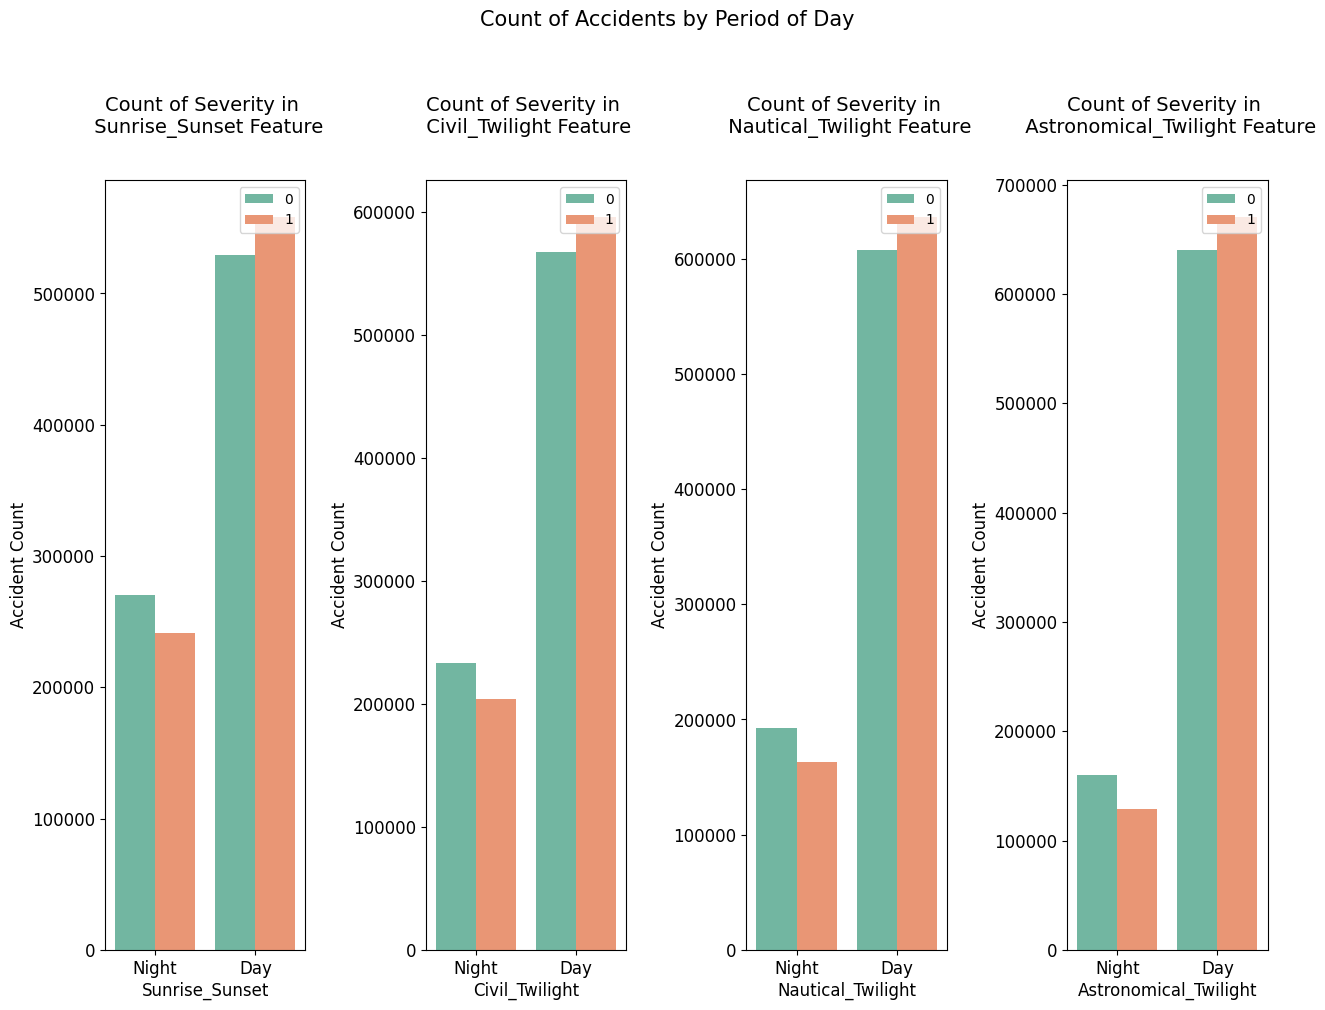

In [27]:
# Assuming `data` is your DataFrame and has 'Weather_Condition' and 'Severity' columns.
period_of_day = ['Sunrise_Sunset','Civil_Twilight','Nautical_Twilight','Astronomical_Twilight']


fig, axs = plt.subplots(1, 4, figsize=(15, 10))  # Create a 3x3 grid
plt.subplots_adjust(hspace=0.4, wspace=0.6)      # Adjust spacing

# Flatten the axs array for easy iteration
axs = axs.flatten()

# Plot for each feature
for i, feature in enumerate(period_of_day):
    re_df = re_df.reset_index(drop=True)

    # Create a countplot in the current axis
    sns.countplot(ax=axs[i], x = feature, hue='Severity', data=re_df, palette="Set2")

    axs[i].set_xlabel(f'{feature}', size=12, labelpad=3)
    axs[i].set_ylabel('Accident Count', size=12, labelpad=3)
    axs[i].tick_params(axis='x', labelsize=12)
    axs[i].tick_params(axis='y', labelsize=12)
    axs[i].legend(['0', '1'], loc='upper right', prop={'size': 10})
    axs[i].set_title(f'Count of Severity in \n {feature} Feature', size=14, y=1.05)

# Hide unused subplots
for j in range(len(weather), len(axs)):
    fig.delaxes(axs[j])

# Add a global title
fig.suptitle('Count of Accidents by Period of Day', fontsize=15,y=1.05)
plt.show()

In [28]:
data = data.drop(['Civil_Twilight','Nautical_Twilight','Astronomical_Twilight'], axis=1)

## Location Feature

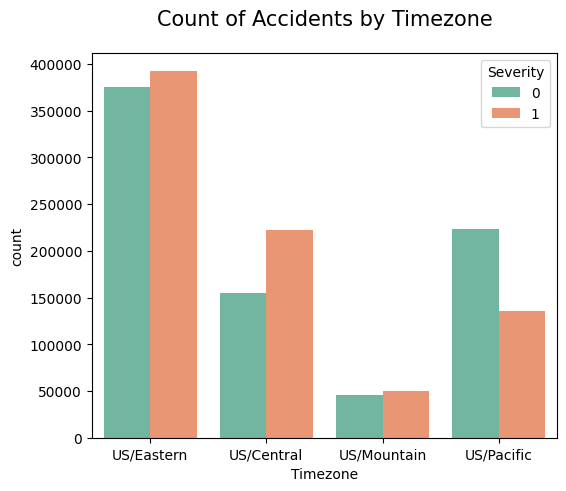

In [29]:
plt.figure(figsize=(6,5))
sns.countplot(x='Timezone', hue='Severity', data=re_df ,palette="Set2")
plt.title("Count of Accidents by Timezone", size=15, y=1.05)
plt.show()

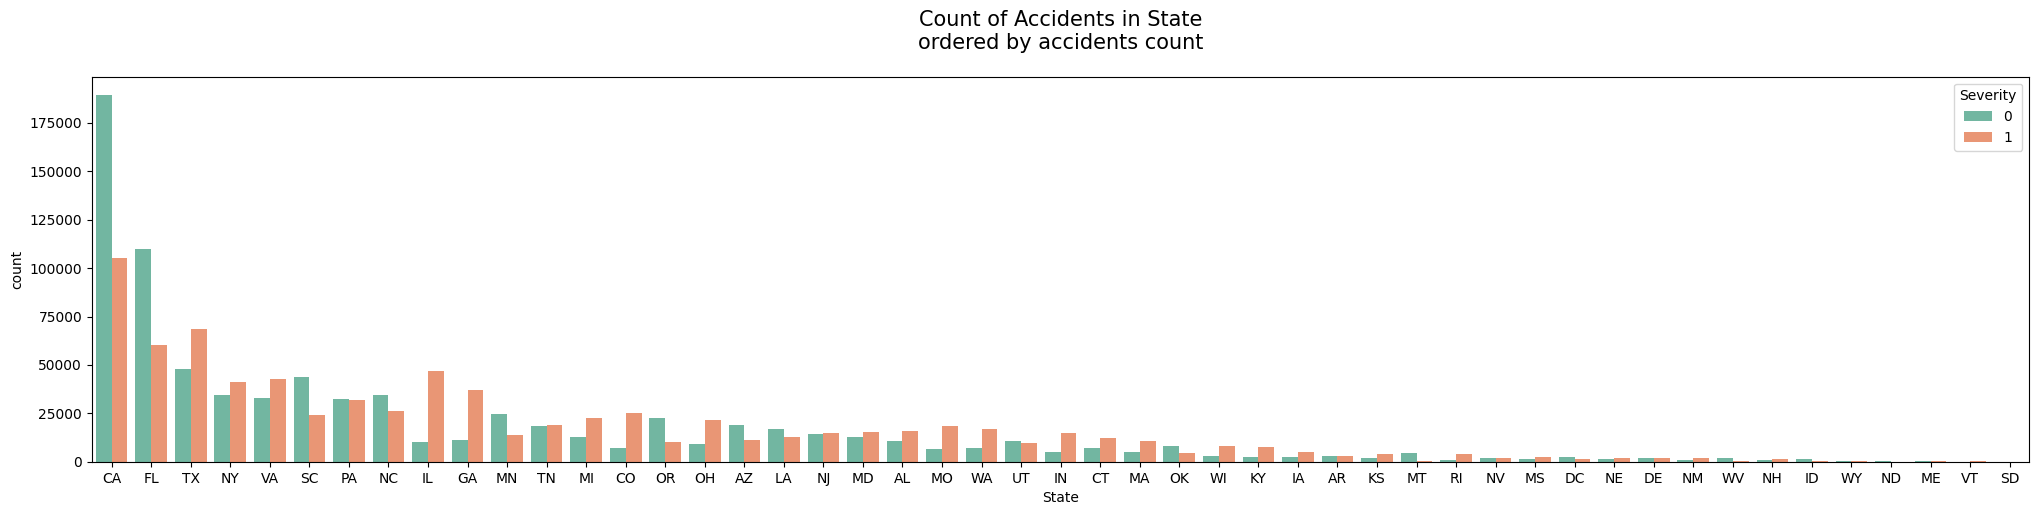

In [30]:
plt.figure(figsize=(25,5))
sns.countplot(x='State', hue='Severity',
                      data=re_df ,palette="Set2", order=re_df['State'].value_counts().index)
plt.title("Count of Accidents in State\nordered by accidents count", size=15, y=1.05)
plt.show()

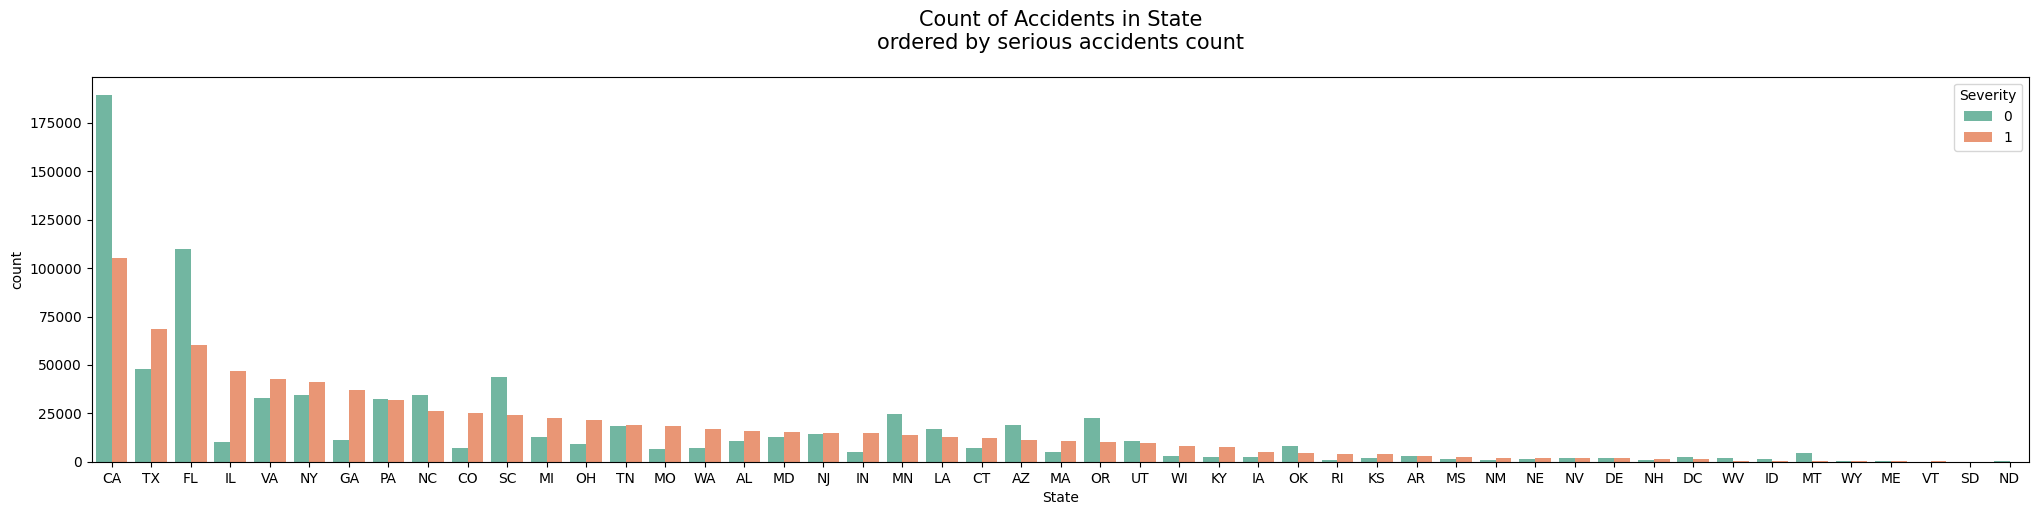

In [31]:
plt.figure(figsize=(25,5))
sns.countplot(x='State', hue='Severity', data=re_df ,palette="Set2", order=re_df[re_df['Severity']==1]['State'].value_counts().index)
plt.title("Count of Accidents in State\nordered by serious accidents count", size=15, y=1.05)
plt.show()

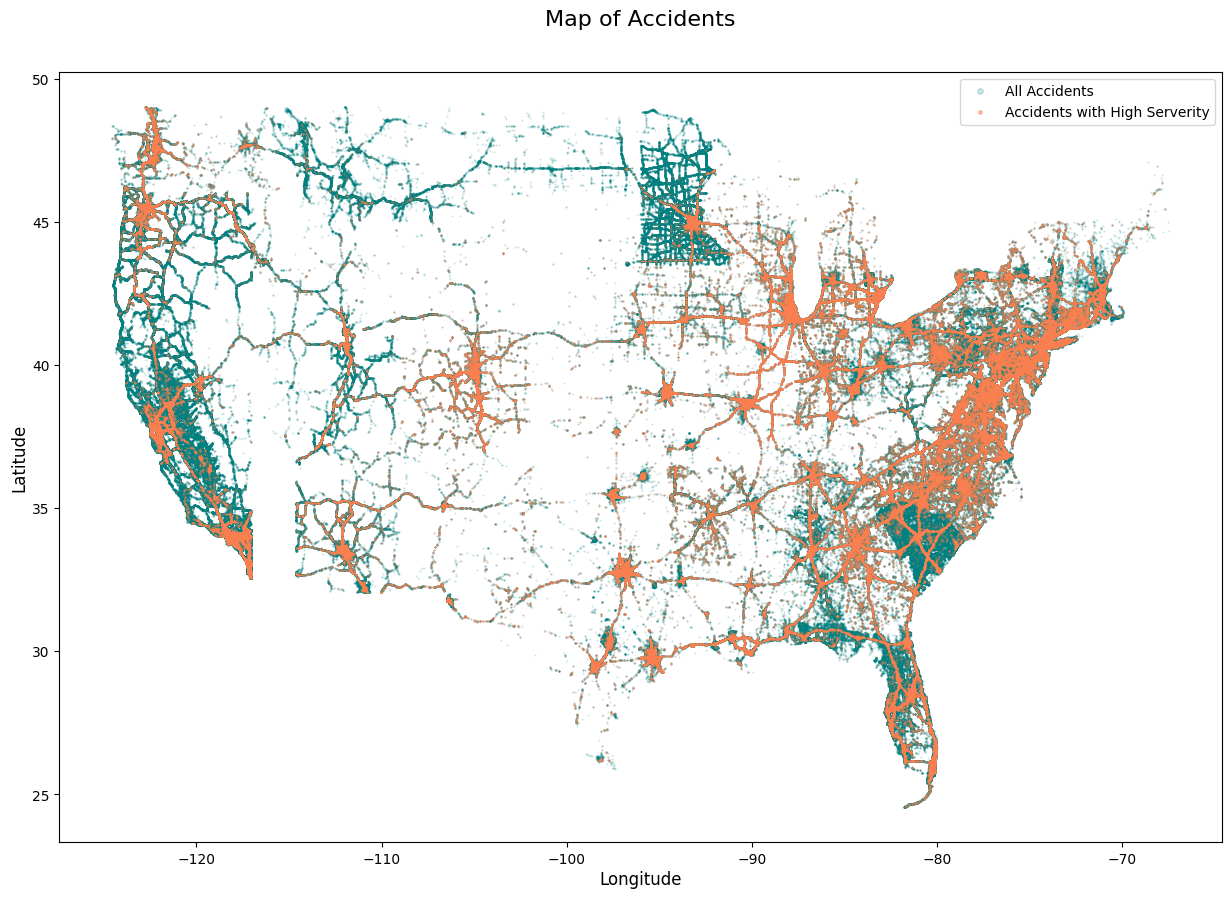

In [32]:
df_4 = data[data['Severity']==1]

plt.figure(figsize=(15,10))

plt.plot( 'Start_Lng', 'Start_Lat', data=data, linestyle='', marker='o', markersize=0.5, color="teal", alpha=0.2, label='All Accidents')
plt.plot( 'Start_Lng', 'Start_Lat', data=df_4, linestyle='', marker='o', markersize=0.3, color="coral", alpha=0.5, label='Accidents with High Serverity')
plt.legend(markerscale=8)
plt.xlabel('Longitude', size=12, labelpad=3)
plt.ylabel('Latitude', size=12, labelpad=3)
plt.title('Map of Accidents', size=16, y=1.05)
plt.show()

## Weather Feature

In [33]:
# extreamly skewed distribution
data['Pressure_bc']= boxcox(data['Pressure(in)'].apply(lambda x: x+1),lmbda=6)
data['Visibility_bc']= boxcox(data['Visibility(mi)'].apply(lambda x: x+1),lmbda = 0.1)
data['Wind_Speed_bc']= boxcox(data['Wind_Speed(mph)'].apply(lambda x: x+1),lmbda=-0.2)
data = data.drop(['Pressure(in)','Visibility(mi)','Wind_Speed(mph)'], axis=1)

re_df = resampleData(data,'Severity',800000)

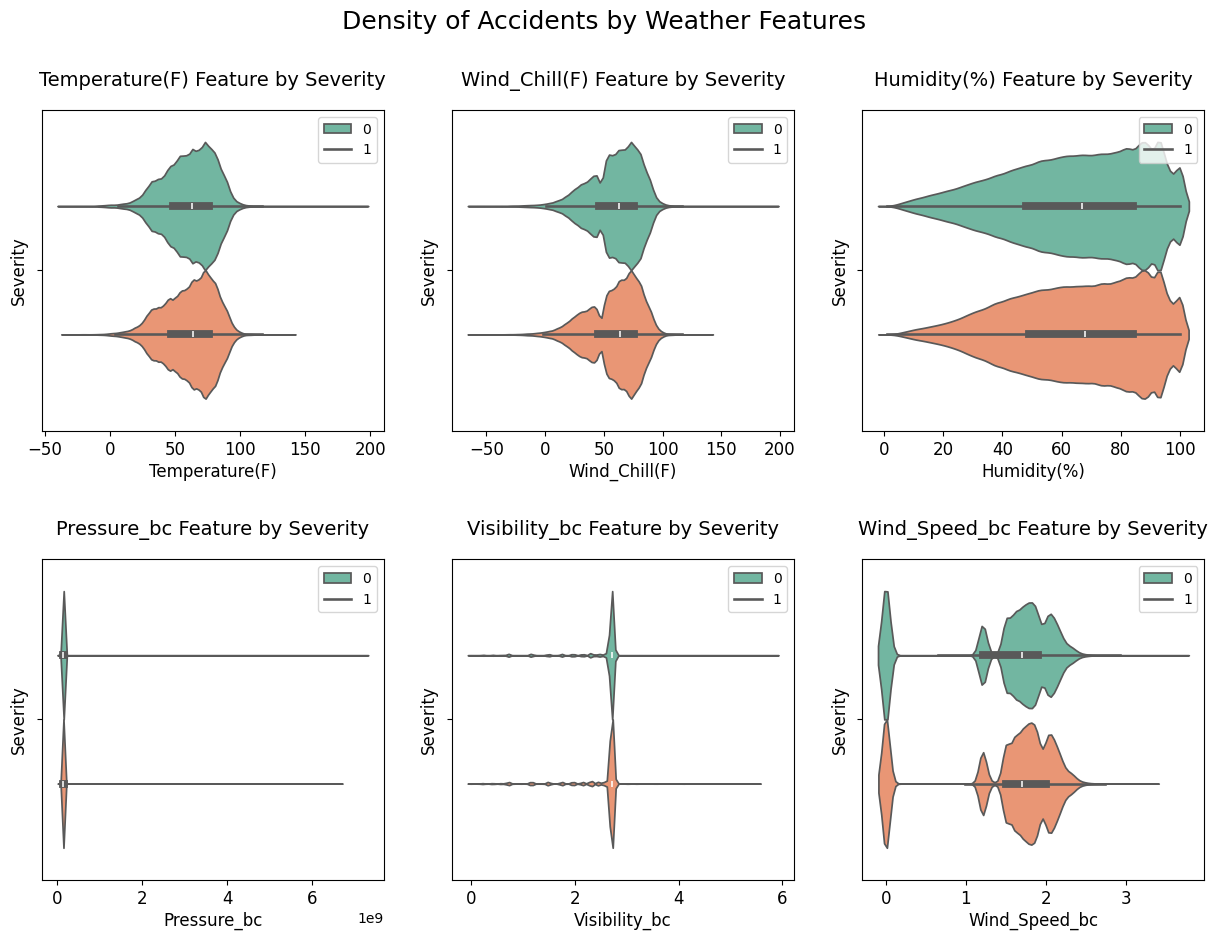

In [34]:
# Assuming `data` is your DataFrame and has 'Weather_Condition' and 'Severity' columns.

num_features = ["Temperature(F)","Wind_Chill(F)","Humidity(%)","Pressure_bc","Visibility_bc","Wind_Speed_bc"]

fig, axs = plt.subplots(2,3, figsize=(15, 10))
plt.subplots_adjust(hspace=0.4,wspace = 0.2)

axs = axs.flatten()

for i, feature in enumerate(num_features):

    sns.violinplot(ax = axs[i], x=feature, hue="Severity", data=re_df, palette="Set2")

    axs[i].set_xlabel(f'{feature}', size=12, labelpad=3)
    axs[i].set_ylabel('Severity', size=12, labelpad=3)
    axs[i].tick_params(axis='x', labelsize=12)
    axs[i].tick_params(axis='y', labelsize=12)

    axs[i].legend(['0', '1'], loc='upper right', prop={'size': 10})
    axs[i].set_title(f'{feature} Feature by Severity', size=14, y=1.05)

fig.suptitle('Density of Accidents by Weather Features', fontsize=18)
plt.show()

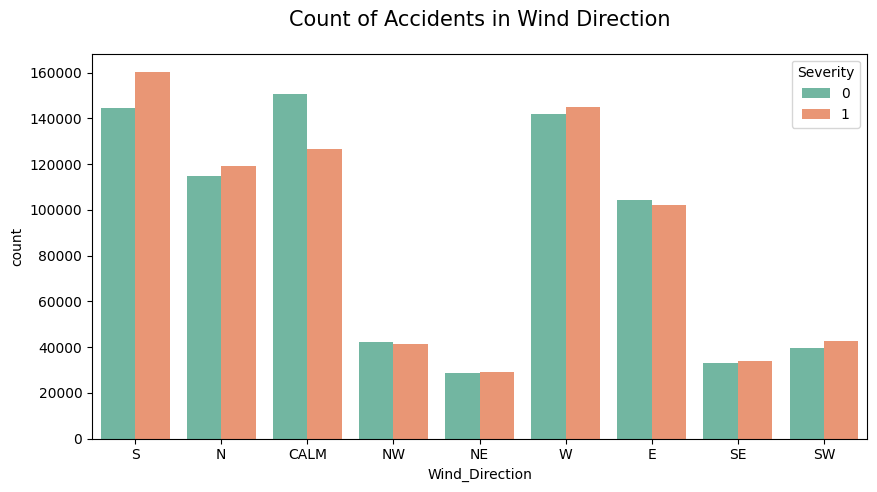

In [35]:
plt.figure(figsize=(10,5))
chart = sns.countplot(x='Wind_Direction', hue='Severity', data=re_df ,palette="Set2")
plt.title("Count of Accidents in Wind Direction", size=15, y=1.05)
plt.show()

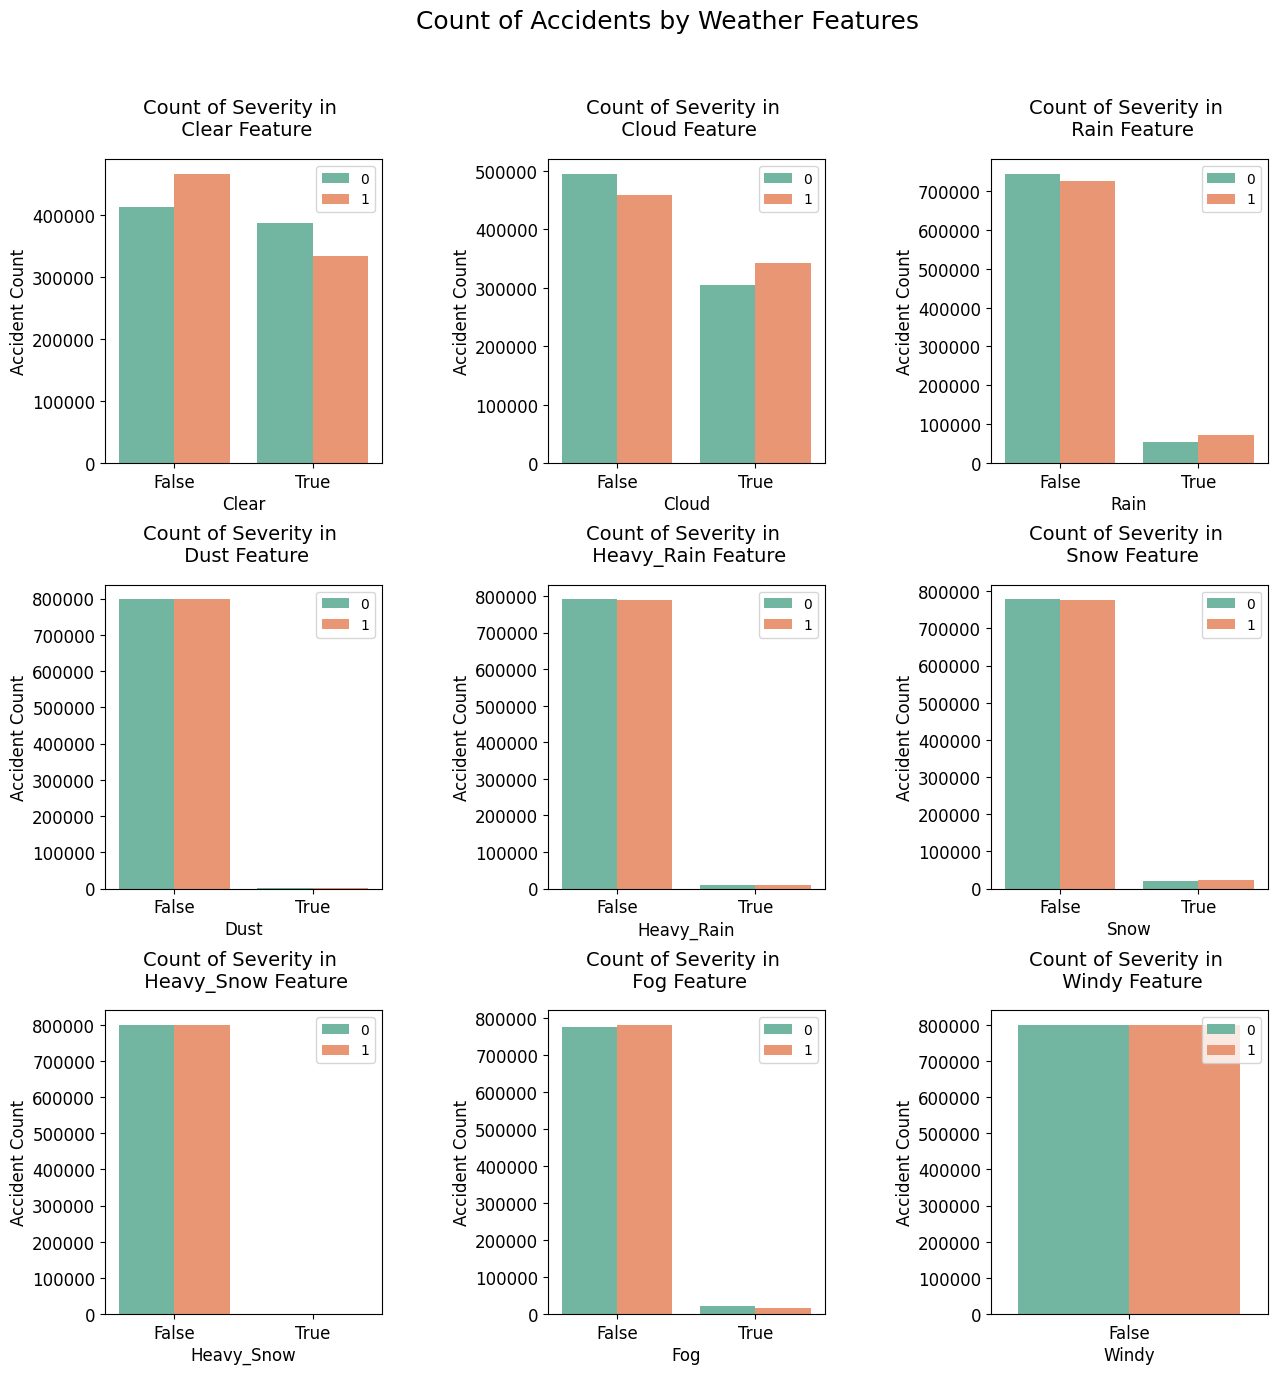

In [36]:
# Assuming `data` is your DataFrame and has 'Weather_Condition' and 'Severity' columns.
weather = ['Clear', 'Cloud', 'Rain', 'Dust', 'Heavy_Rain', 'Snow', 'Heavy_Snow', 'Fog','Windy']

fig, axs = plt.subplots(3, 3, figsize=(15, 15))  # Create a 3x3 grid
plt.subplots_adjust(hspace=0.4, wspace=0.6)      # Adjust spacing

# Flatten the axs array for easy iteration
axs = axs.flatten()

# Plot for each feature
for i, feature in enumerate(weather):
    # Add a new column to indicate the condition for the feature
    re_df[feature] = re_df['Weather_Condition'] == feature

    # Create a countplot in the current axis
    sns.countplot(ax=axs[i], x=feature, hue='Severity', data=re_df, palette="Set2")

    axs[i].set_xlabel(f'{feature}', size=12, labelpad=3)
    axs[i].set_ylabel('Accident Count', size=12, labelpad=3)
    axs[i].tick_params(axis='x', labelsize=12)
    axs[i].tick_params(axis='y', labelsize=12)
    axs[i].legend(['0', '1'], loc='upper right', prop={'size': 10})
    axs[i].set_title(f'Count of Severity in \n {feature} Feature', size=14, y=1.05)

    # Drop the column to clean up
    re_df = re_df.drop([feature], axis=1)

# Hide unused subplots
for j in range(len(weather), len(axs)):
    fig.delaxes(axs[j])

# Add a global title
fig.suptitle('Count of Accidents by Weather Features', fontsize=18)
plt.show()

In [37]:
data = data.loc[data['Weather_Condition'] != "Fog"]
data = data.loc[data['Weather_Condition'] != "Windy"]
data = data.loc[data['Weather_Condition'] != "Dust"]

print(data['Severity'].value_counts())

re_df = resampleData(data,'Severity',700000)

Severity
0    4282507
1     671647
Name: count, dtype: int64


## Point Of Interest (POI) Feature

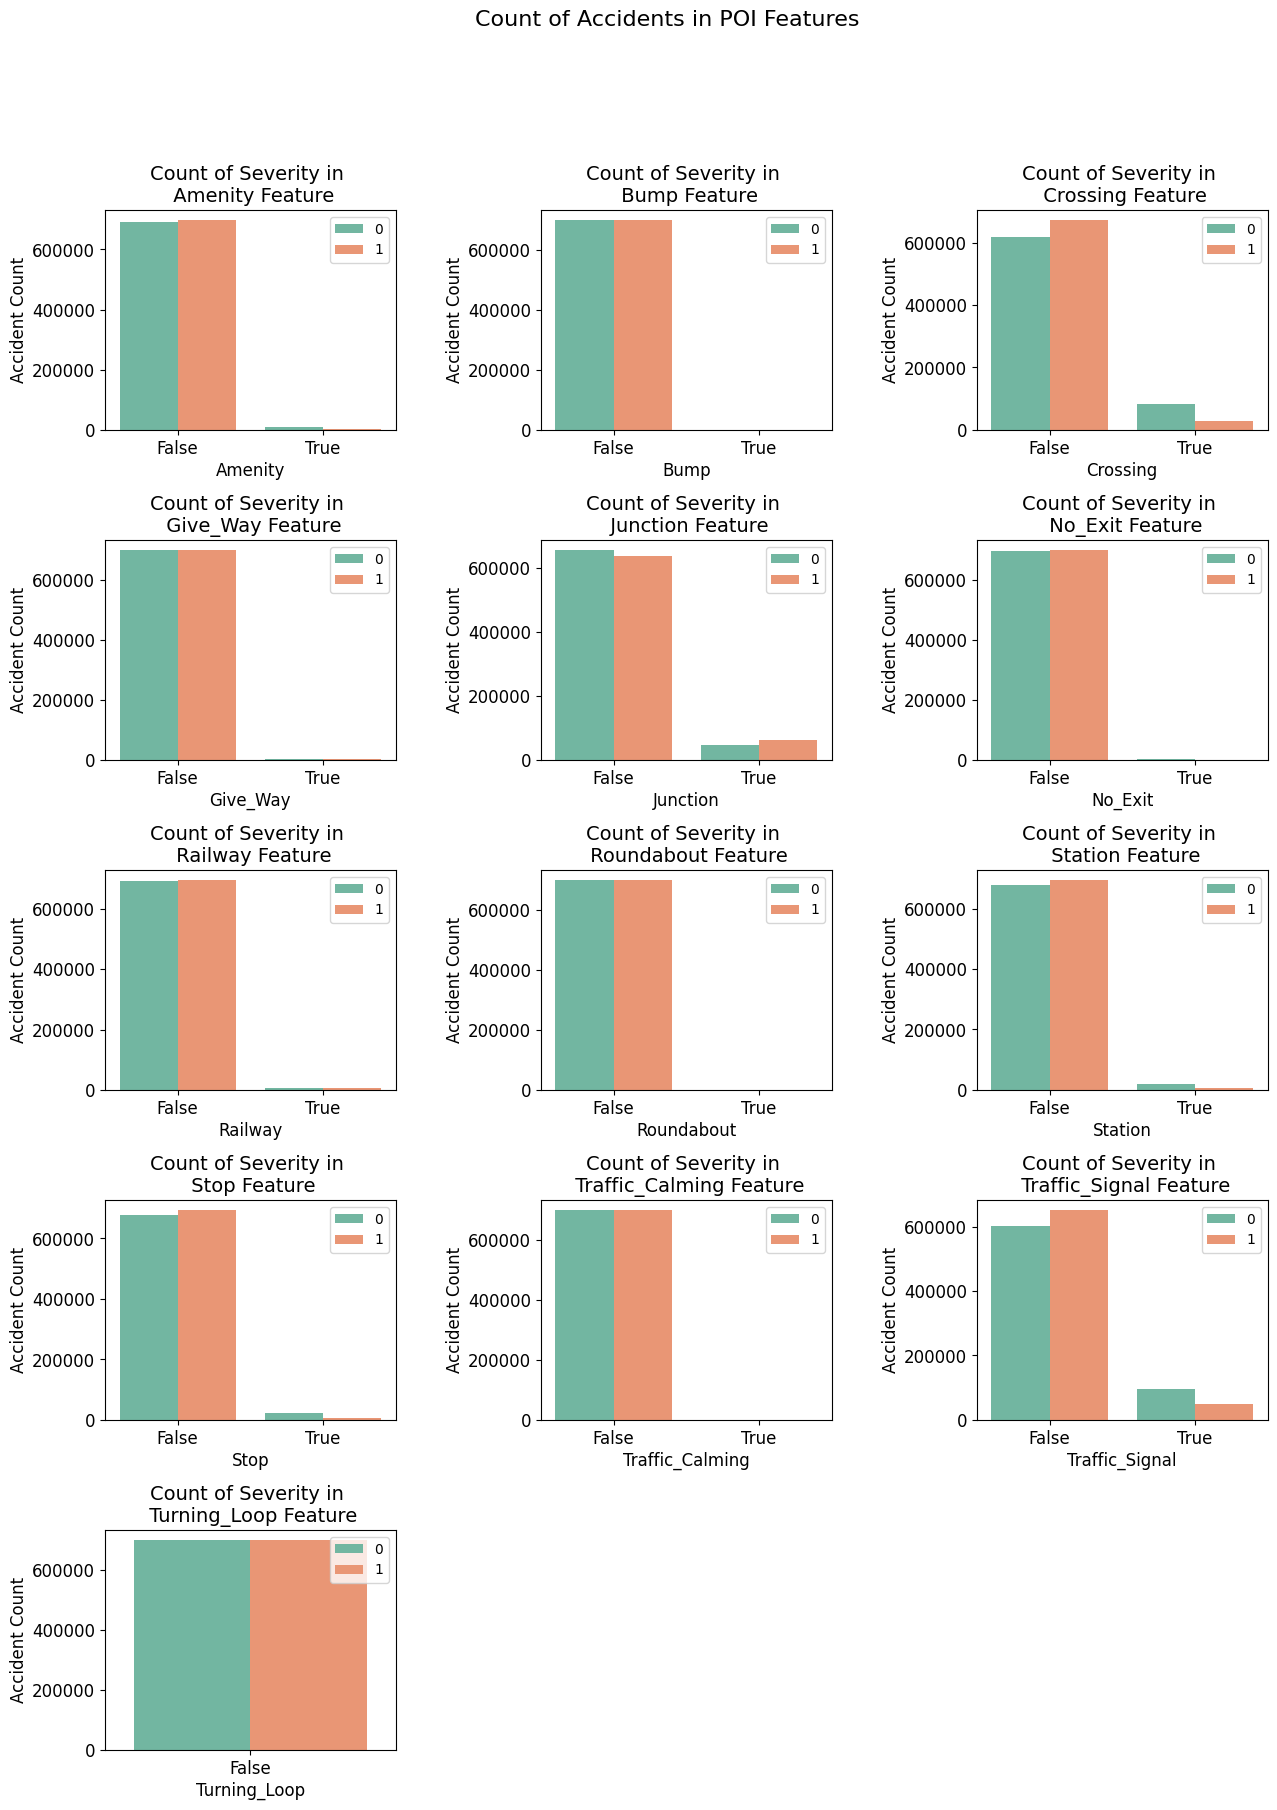

In [38]:
POI_features = ['Amenity','Bump','Crossing','Give_Way','Junction','No_Exit','Railway','Roundabout','Station','Stop','Traffic_Calming','Traffic_Signal','Turning_Loop']

fig, axs = plt.subplots(ncols=3, nrows=5, figsize=(15, 20))
plt.subplots_adjust(hspace=0.5,wspace = 0.5)

axs = axs.flatten()

for i, feature in enumerate(POI_features):

    sns.countplot(ax=axs[i], x=feature, hue='Severity', data=re_df, palette="Set2")

    axs[i].set_xlabel(f'{feature}', size=12, labelpad=3)
    axs[i].set_ylabel('Accident Count', size=12, labelpad=3)
    axs[i].tick_params(axis='x', labelsize=12)
    axs[i].tick_params(axis='y', labelsize=12)
    axs[i].legend(['0', '1'], loc='upper right', prop={'size': 10})
    axs[i].set_title(f'Count of Severity in \n {feature} Feature', size=14)

# Hide unused subplots
for j in range(len(POI_features), len(axs)):
    fig.delaxes(axs[j])

fig.suptitle('Count of Accidents in POI Features', fontsize=16)
plt.show()

In [39]:
data = data.drop(['Amenity','Bump','Give_Way',"No_Exit","Railway","Roundabout","Traffic_Calming","Turning_Loop"], axis  = 1)

## Correlation

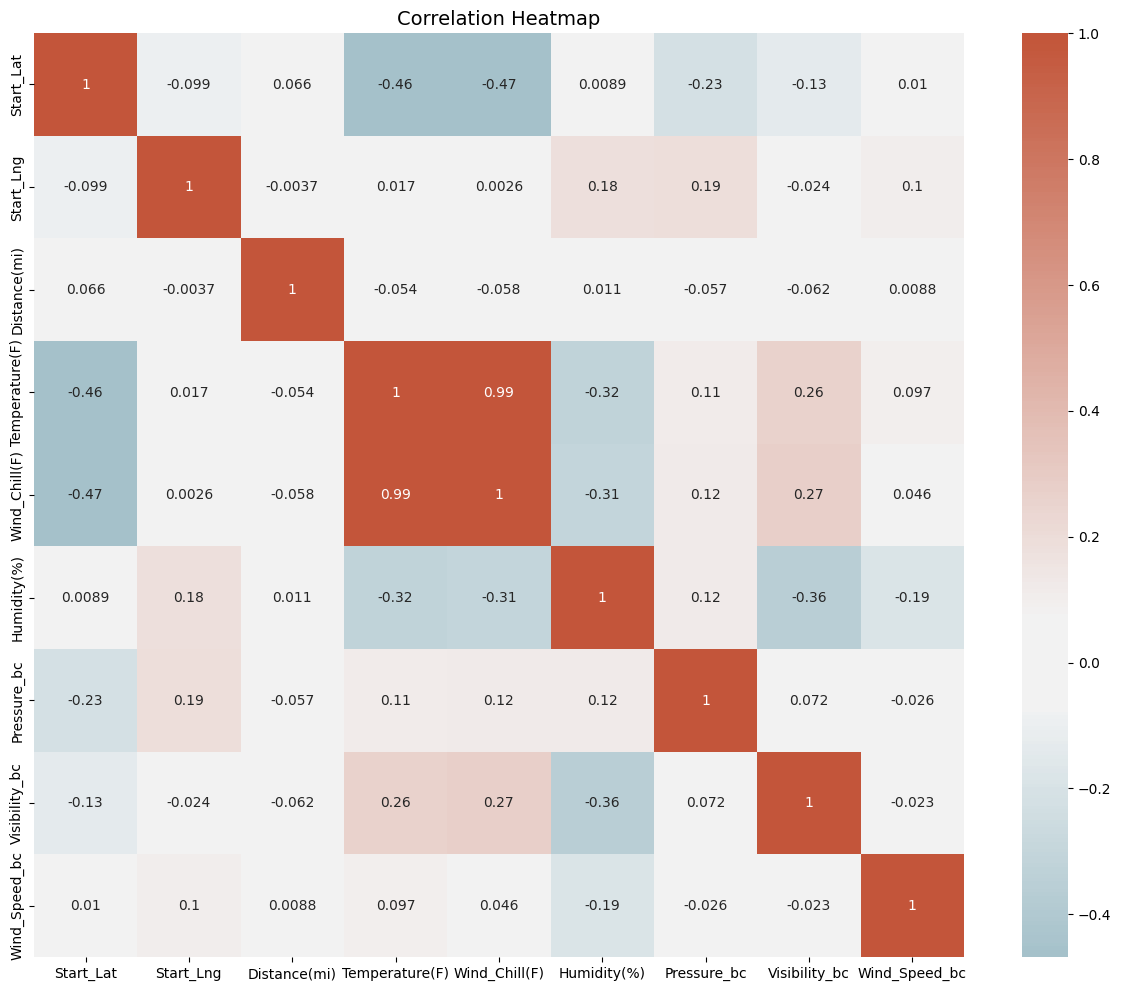

In [40]:
continous_data = data[["Start_Lat","Start_Lng","Distance(mi)","Temperature(F)","Wind_Chill(F)","Humidity(%)","Pressure_bc","Visibility_bc","Wind_Speed_bc"]]

data['Severity'] = data['Severity'].astype(int)
plt.figure(figsize=(15,12))
cmap = sns.diverging_palette(220, 20, sep=20, as_cmap=True)
sns.heatmap(continous_data.corr(), annot=True,cmap=cmap, center=0).set_title("Correlation Heatmap", fontsize=14)
plt.show()

In [41]:
data = data.drop(['Wind_Chill(F)'],axis=1)

# Model

In [ ]:
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from lightgbm import LGBMClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,recall_score,precision_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping # Import EarlyStopping
from sklearn.preprocessing import LabelEncoder # Cần cho phần chuẩn bị MLP
from sklearn.utils import class_weight as sk_class_weight # Để tránh nhầm tên

import time

In [43]:
data = data.replace([True, False], [1,0])

encoder = LabelEncoder()

categories_features = ['State','Timezone','Wind_Direction','Weather_Condition','Sunrise_Sunset',]

for feature in categories_features:
  data[feature] = encoder.fit_transform(data[feature])

C:\Users\THANH TAN\AppData\Local\Temp\ipykernel_6508\2877595321.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data = data.replace([True, False], [1,0])


In [44]:
def getResult(y_test,y_pred):
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  print('Accuracy:',accuracy)
  print('Precision:',precision)
  print('Recall:', recall)
  print('F1 score:',f1)
  print('Confusion matrix:')
  print(confusion_matrix(y_test, y_pred))
  return [accuracy,precision,recall,f1]

In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4954154 entries, 512217 to 7728393
Data columns (total 24 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Severity           int64  
 1   Start_Lat          float64
 2   Start_Lng          float64
 3   Distance(mi)       float64
 4   State              int64  
 5   Timezone           int64  
 6   Temperature(F)     float64
 7   Humidity(%)        float64
 8   Wind_Direction     int64  
 9   Weather_Condition  int64  
 10  Crossing           int64  
 11  Junction           int64  
 12  Station            int64  
 13  Stop               int64  
 14  Traffic_Signal     int64  
 15  Sunrise_Sunset     int64  
 16  Year               int32  
 17  Month              int32  
 18  Day                int32  
 19  Hour               int32  
 20  Week               int32  
 21  Pressure_bc        float64
 22  Visibility_bc      float64
 23  Wind_Speed_bc      float64
dtypes: float64(8), int32(5), int64(11)
memory usage: 8

In [46]:
# split X, y
X = data.drop('Severity', axis=1)
y= data['Severity']

X = StandardScaler().fit_transform(X)
# split train, test
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)

In [47]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [48]:
neg_count = np.sum(y_train == 0)
pos_count = np.sum(y_train == 1)
if pos_count > 0:
    scale_pos_weight_value = neg_count / pos_count
    print(f"Calculated scale_pos_weight: {scale_pos_weight_value:.2f}")
else:
    scale_pos_weight_value = 1 # Giá trị mặc định nếu không có lớp dương
    print("Warning: No positive samples found in y_train. Setting scale_pos_weight to 1.")

Calculated scale_pos_weight: 6.38


## LogisticRegression

In [49]:
lr = LogisticRegression(random_state=0, class_weight='balanced', max_iter=1000)
lr.fit(X_train,y_train)
y_pred=lr.predict(X_test)

In [50]:
lr_result = ['Logistic Regression'] + getResult(y_test,y_pred)

Accuracy: 0.6756689836884447
Precision: 0.24573847157772621
Recall: 0.6728190417580673
F1 score: 0.3599938394049715
Confusion matrix:
[[868642 416111]
 [ 65925 135569]]


## Naive Bayes

In [51]:
NB = GaussianNB()
NB.fit(X_train, y_train)
y_pred = NB.predict(X_test)

In [52]:
nb_result = ['Naive Bayes'] + getResult(y_test,y_pred)

Accuracy: 0.7246547848372444
Precision: 0.24845308644068206
Recall: 0.5091516372695961
F1 score: 0.3339480121677113
Confusion matrix:
[[974425 310328]
 [ 98903 102591]]


## Decision Tree

In [53]:
dstree = DecisionTreeClassifier(criterion='gini', max_depth=10, min_samples_split=2, random_state=42, class_weight='balanced')
dstree.fit(X_train, y_train)
y_pred = dstree.predict(X_test)

In [54]:
dstree_result = ['Decision Tree'] + getResult(y_test,y_pred)

Accuracy: 0.7966623313621491
Precision: 0.3835696251699359
Recall: 0.8233495786475031
F1 score: 0.5233355940758032
Confusion matrix:
[[1018137  266616]
 [  35594  165900]]


## Random Forest

In [55]:
rf = RandomForestClassifier(criterion='gini', max_depth=10, min_samples_split=2, n_estimators = 10, random_state=42,  class_weight='balanced')
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [56]:
rf_result = ['Random Forest'] + getResult(y_test,y_pred)

Accuracy: 0.7822037655921257
Precision: 0.3651876154187287
Recall: 0.8214537405580316
F1 score: 0.505603030233606
Confusion matrix:
[[997030 287723]
 [ 35976 165518]]


## XGBoost

In [64]:
xgb = XGBClassifier(random_state=42,
                    scale_pos_weight=scale_pos_weight_value,
                    n_estimators=100, # Có thể tăng/giảm để thử nghiệm
                    max_depth=5,      # Có thể thay đổi
                    # use_label_encoder=False,
                    eval_metric='logloss')
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)


In [65]:
print("Evaluating XGBoost Classifier:")
xgb_result = ['XGBoost'] + getResult(y_test, y_pred_xgb)

Evaluating XGBoost Classifier:
Accuracy: 0.815841512211631
Precision: 0.41189891147067365
Recall: 0.8377619184690362
F1 score: 0.5522670056092378
Confusion matrix:
[[1043738  241015]
 [  32690  168804]]


## LightGBM Classifier

In [66]:
lgbm = LGBMClassifier(random_state=42,
                      scale_pos_weight=scale_pos_weight_value,
                      n_estimators=100, # Có thể tăng/giảm
                      max_depth=5       # Có thể thay đổi (hoặc dùng num_leaves)
                     )
lgbm.fit(X_train, y_train)
y_pred_lgbm = lgbm.predict(X_test)

[LightGBM] [Info] Number of positive: 470153, number of negative: 2997754
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.100660 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1521
[LightGBM] [Info] Number of data points in the train set: 3467907, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.135573 -> initscore=-1.852560
[LightGBM] [Info] Start training from score -1.852560


c:\Users\THANH TAN\Desktop\HT\242\ML\BTL\USAccidents\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [67]:
print("Evaluating LightGBM Classifier:")
lgbm_result = ['LightGBM'] + getResult(y_test, y_pred_lgbm)

Evaluating LightGBM Classifier:
Accuracy: 0.7958233052783286
Precision: 0.3830444706988908
Recall: 0.8286648733957339
F1 score: 0.5239135925848645
Confusion matrix:
[[1015819  268934]
 [  34523  166971]]


### With SMOTE

In [61]:
print("\n--- Testing SMOTE ---")

# Tạo pipeline SMOTE + LGBM
smote_lgbm_pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('lgbm', LGBMClassifier(random_state=42, n_estimators=100, max_depth=5)) # Bỏ scale_pos_weight
])

print("Training LGBM with SMOTE...")
# Huấn luyện pipeline trên dữ liệu gốc train (SMOTE chỉ áp dụng bên trong pipeline khi fit)
smote_lgbm_pipeline.fit(X_train, y_train) # Sử dụng X_train, y_train gốc (trước SMOTE)
y_pred_smote_lgbm = smote_lgbm_pipeline.predict(X_test)




--- Testing SMOTE ---
Training LGBM with SMOTE...
[LightGBM] [Info] Number of positive: 2997754, number of negative: 2997754
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.327210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4455
[LightGBM] [Info] Number of data points in the train set: 5995508, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\THANH TAN\Desktop\HT\242\ML\BTL\USAccidents\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [62]:
print("Evaluating LGBM with SMOTE:")
smote_lgbm_result = ['LGBM (SMOTE)'] + getResult(y_test, y_pred_smote_lgbm)

Evaluating LGBM with SMOTE:
Accuracy: 0.859215863850356
Precision: 0.48526479987825294
Recall: 0.6330064418791627
F1 score: 0.5493760956552827
Confusion matrix:
[[1149460  135293]
 [  73947  127547]]


In [ ]:
RUN_HYPERPARAMETER_TUNING = True # Đặt thành True để chạy

if RUN_HYPERPARAMETER_TUNING:
    print("\n--- Starting Hyperparameter Tuning for LightGBM (Balanced) ---")
    # ===> BỔ SUNG: Tối ưu kiểu dữ liệu sang float32 <===
    print(f"Original X_train dtype: {X_train.dtype}")
    if hasattr(X_train, 'dtype') and X_train.dtype == 'float64':
        try:
            print("Converting X_train and X_test to float32 to save memory...")
            X_train = X_train.astype(np.float32)
            X_test = X_test.astype(np.float32) # Quan trọng: đổi cả X_test
            print(f"Converted X_train dtype to: {X_train.dtype}")
            gc.collect() # Gọi thu gom rác
        except Exception as e:
            print(f"Warning: Could not convert dtype to float32: {e}")
    # ===================================================

    # ===> BỔ SUNG: Lấy mẫu nhỏ hơn cho tuning <===
    SAMPLE_SIZE_TUNING = 0.15 # Ví dụ: dùng 15% dữ liệu train để tuning (điều chỉnh nếu cần)
    # Kiểm tra nếu kích thước mẫu > kích thước dữ liệu gốc (trường hợp dữ liệu rất nhỏ)
    actual_sample_size = min(SAMPLE_SIZE_TUNING, 1.0)
    print(f"Taking {actual_sample_size*100:.1f}% sample of training data for tuning...")
    X_train_tune, _, y_train_tune, _ = train_test_split(
        X_train, y_train,
        train_size=actual_sample_size,
        random_state=42,
        stratify=y_train # Giữ tỷ lệ lớp trong mẫu
    )
    print(f"Tuning will be performed on a sample of size: {X_train_tune.shape[0]}")
    # ============================================

    # Định nghĩa không gian tham số cần tìm kiếm (giữ nguyên)
    param_distributions = {
        'n_estimators': [100, 200, 300, 500],
        'learning_rate': [0.01, 0.05, 0.1],
        'num_leaves': [20, 31, 40, 50],
        'max_depth': [-1, 5, 7, 10],
        'reg_alpha': [0, 0.1, 0.5, 1],
        'reg_lambda': [0, 0.1, 0.5, 1],
        'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
        'subsample': [0.7, 0.8, 0.9, 1.0],
    }

    # Khởi tạo mô hình cơ sở với scale_pos_weight đã tính (giữ nguyên)
    # Đảm bảo lgbm_base cũng dùng dtype phù hợp nếu cần (thường thì không cần rõ ràng)
    lgbm_base = LGBMClassifier(random_state=42, scale_pos_weight=scale_pos_weight_value)

    # Thiết lập StratifiedKFold (giữ nguyên)
    cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    # Thiết lập RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=lgbm_base,
        param_distributions=param_distributions,
        n_iter=30,  # ===> THAY ĐỔI: Giảm n_iter xuống 30 (có thể tăng lại nếu có tài nguyên)
        scoring='f1', # Hoặc 'recall'
        cv=cv_strategy,
        n_jobs=4,   # ===> THAY ĐỔI: Giảm n_jobs xuống 4 (hoặc 2, hoặc 1 nếu vẫn lỗi)
        random_state=42,
        verbose=2
    )

    print("Running Randomized Search CV on data sample...")
    start_time_tuning = time.time()
    try:
        # ===> THAY ĐỔI: Fit trên mẫu nhỏ hơn <===
        random_search.fit(X_train_tune, y_train_tune)
        tuning_duration = time.time() - start_time_tuning
        print(f"Tuning completed in {tuning_duration:.2f} seconds.")

        print(f"Best parameters found: {random_search.best_params_}")
        print(f"Best F1 score on CV (sample): {random_search.best_score_:.4f}")

        # Lấy mô hình tốt nhất VÀ huấn luyện lại trên TOÀN BỘ dữ liệu train
        print("\nTraining best model on full training data...")
        best_lgbm = random_search.best_estimator_ # Lấy cấu hình tốt nhất
        start_time_retrain = time.time()
        best_lgbm.fit(X_train, y_train) # Huấn luyện lại trên X_train đầy đủ
        retrain_duration = time.time() - start_time_retrain
        print(f"Retraining best model completed in {retrain_duration:.2f} seconds.")


        # Đánh giá mô hình tốt nhất trên tập test (giữ nguyên)
        y_pred_best_lgbm = best_lgbm.predict(X_test)
        print("\nEvaluating Best Tuned LightGBM (Balanced):")
        tuned_lgbm_result = ['LGBM (Balanced, Tuned)'] + getResult(y_test, y_pred_best_lgbm)

    except MemoryError as me:
        print("\nERROR: MemoryError occurred during RandomizedSearchCV even with sampling.")
        print("Consider further reducing SAMPLE_SIZE_TUNING, n_iter, n_jobs, or increasing system RAM.")
        tuned_lgbm_result = None
    except Exception as e:
        print(f"\nAn error occurred during RandomizedSearchCV: {e}")
        tuned_lgbm_result = None

else:
    print("\nSkipping Hyperparameter Tuning.")
    tuned_lgbm_result = None # Đặt là None nếu không chạy tuning


--- Starting Hyperparameter Tuning for LightGBM (Balanced) ---
Original X_train dtype: float32
Taking 15.0% sample of training data for tuning...
Tuning will be performed on a sample of size: 520186
Running Randomized Search CV on data sample...
Fitting 3 folds for each of 30 candidates, totalling 90 fits
[LightGBM] [Info] Number of positive: 70523, number of negative: 449663
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026847 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1517
[LightGBM] [Info] Number of data points in the train set: 520186, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.135573 -> initscore=-1.852560
[LightGBM] [Info] Start training from score -1.852560
Tuning completed in 305.42 seconds.
Best parameters found: {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 1, 'num_leaves': 40, 'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.05, 'colsa

c:\Users\THANH TAN\Desktop\HT\242\ML\BTL\USAccidents\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



Evaluating Best Tuned LightGBM (Balanced):
Accuracy: 0.8172672510020206
Precision: 0.4141037832962422
Recall: 0.8385162833632763
F1 score: 0.5544103508132923
Confusion matrix:
[[1045705  239048]
 [  32538  168956]]


## MLP


In [70]:
categorical_cols_mlp = ['State', 'Timezone', 'Wind_Direction', 'Weather_Condition', 'Sunrise_Sunset', 'Crossing', 'Junction', 'Station', 'Stop', 'Traffic_Signal']
numerical_cols_mlp = ['Start_Lat', 'Start_Lng', 'Distance(mi)', 'Temperature(F)', 'Humidity(%)', 'Year', 'Month', 'Day', 'Hour', 'Week', 'Pressure_bc', 'Visibility_bc', 'Wind_Speed_bc'] # Kiểm tra lại

data_mlp = data.copy() # Sử dụng data gốc trước khi LabelEncode/Scale cho các mô hình sklearn

# Mã hóa cột phân loại thành số nguyên cho MLP
label_encoders_mlp = {}
for col in categorical_cols_mlp:
    le = LabelEncoder()
    data_mlp[col] = data_mlp[col].astype(str)
    data_mlp[col] = le.fit_transform(data_mlp[col])
    label_encoders_mlp[col] = le

# Chuẩn hóa cột số cho MLP
scaler_mlp = StandardScaler()
data_mlp[numerical_cols_mlp] = scaler_mlp.fit_transform(data_mlp[numerical_cols_mlp])

# Tách X và y cho MLP
X_mlp_df = data_mlp.drop('Severity', axis=1) # Giữ dạng DataFrame
y_mlp = data_mlp['Severity']

# Tách train/test cho MLP (sử dụng cùng random_state và stratify)
X_train_mlp_df, X_test_mlp_df, y_train_mlp, y_test_mlp = train_test_split(X_mlp_df, y_mlp, test_size=0.30, random_state=42, stratify=y_mlp)

# Định dạng lại X thành danh sách các input cho Keras
X_train_list = [X_train_mlp_df[numerical_cols_mlp].values]
X_test_list = [X_test_mlp_df[numerical_cols_mlp].values]
for col in categorical_cols_mlp:
    X_train_list.append(X_train_mlp_df[col].values)
    X_test_list.append(X_test_mlp_df[col].values)

# Tính class_weight cho Keras
class_weights_mlp = sk_class_weight.compute_class_weight(
    'balanced', classes=np.unique(y_train_mlp), y=y_train_mlp
)
class_weight_dict_mlp = dict(enumerate(class_weights_mlp))
print(f"Calculated class weights for Keras: {class_weight_dict_mlp}")

# Xây dựng mô hình MLP (Giữ kiến trúc cơ bản, thêm Dropout)
input_layers = []
embedding_layers = []
input_numeric = layers.Input(shape=(len(numerical_cols_mlp),), name='input_numeric')
input_layers.append(input_numeric)
embedding_layers.append(input_numeric)

for col in categorical_cols_mlp:
    num_unique_values = data_mlp[col].nunique() + 1
    embedding_dim = min(50, int(num_unique_values / 2))
    input_cat = layers.Input(shape=(1,), name=f'input_{col}')
    input_layers.append(input_cat)
    embedding = layers.Embedding(input_dim=num_unique_values, output_dim=embedding_dim, name=f'embedding_{col}')(input_cat)
    embedding = layers.Flatten(name=f'flatten_{col}')(embedding)
    embedding_layers.append(embedding)

merged_inputs = layers.concatenate(embedding_layers, name='concatenate_embeddings')
dense1 = layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001), name='dense_1')(merged_inputs) # Thêm L2 reg
bn1 = layers.BatchNormalization(name='batchnorm_1')(dense1)
dropout1 = layers.Dropout(0.4, name='dropout_1')(bn1) # Tăng nhẹ Dropout
dense2 = layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001), name='dense_2')(dropout1) # Thêm L2 reg
bn2 = layers.BatchNormalization(name='batchnorm_2')(dense2)
dropout2 = layers.Dropout(0.4, name='dropout_2')(bn2) # Tăng nhẹ Dropout
output_layer = layers.Dense(1, activation='sigmoid', name='output')(dropout2)
model_mlp = keras.Model(inputs=input_layers, outputs=output_layer)
model_mlp.summary()

# Biên dịch mô hình
model_mlp.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), # Giữ Adam, lr mặc định
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])

# ----- BỔ SUNG: Early Stopping -----
early_stopping = EarlyStopping(
    monitor='val_recall', # Theo dõi Recall trên tập validation
    patience=5,          # Dừng nếu Recall không cải thiện sau 5 epochs
    mode='max',          # Vì chúng ta muốn Recall càng cao càng tốt
    restore_best_weights=True # Khôi phục trọng số của epoch tốt nhất
)
# ----------------------------------

# Huấn luyện mô hình với Early Stopping
EPOCHS = 30 # Tăng số epochs vì có EarlyStopping
BATCH_SIZE = 1024
history = model_mlp.fit(
    X_train_list,
    y_train_mlp,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    class_weight=class_weight_dict_mlp,
    callbacks=[early_stopping], # Thêm callback EarlyStopping
    verbose=1
)

Calculated class weights for Keras: {0: np.float64(0.5784175419330605), 1: np.float64(3.6880621840124386)}


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_State         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_Timezone      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_Wind_Directi… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_Weather_Cond… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_Sunrise_Suns… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_Crossing      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_Junction      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_Station       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_Stop          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_Traffic_Sign… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_State     │ (None, 1, 25)     │      1,250 │ input_State[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_Timezone  │ (None, 1, 2)      │         10 │ input_Timezone[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_Wind_Dir… │ (None, 1, 5)      │         50 │ input_Wind_Direc… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_Weather_… │ (None, 1, 3)      │         21 │ input_Weather_Co… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_Sunrise_… │ (None, 1, 1)      │          3 │ input_Sunrise_Su… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_Crossing  │ (None, 1, 1)      │          3 │ input_Crossing[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_Junction  │ (None, 1, 1)      │          3 │ input_Junction[0

 Total params: 17,478 (68.27 KB)

 Trainable params: 17,094 (66.77 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/30
2710/2710 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.6978 - loss: 0.6517 - precision: 0.2718 - recall: 0.7119 - val_accuracy: 0.7709 - val_loss: 0.4922 - val_precision: 0.3503 - val_recall: 0.8014
Epoch 2/30
2710/2710 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.7723 - loss: 0.4931 - precision: 0.3479 - recall: 0.7832 - val_accuracy: 0.7830 - val_loss: 0.4610 - val_precision: 0.3648 - val_recall: 0.8034
Epoch 3/30
2710/2710 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.7754 - loss: 0.4868 - precision: 0.3535 - recall: 0.7911 - val_accuracy: 0.7917 - val_loss: 0.4663 - val_precision: 0.3752 - val_recall: 0.7999
Epoch 4/30
2710/2710 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.7779 - loss: 0.4834 - precision: 0.3562 - recall: 0.7926 - val_accuracy: 0.7947 - val_loss: 0.4576 - val_precision: 0.3784 - val_recall: 0.7936
Epoch 5/30
2710/2710 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.7775 - loss: 0.4824 - precision: 0.3555 - recall: 0.7950 - val_accuracy: 0.7926

In [71]:
# Đánh giá mô hình MLP
print("\nEvaluating MLP with Early Stopping:")
y_pred_proba_mlp = model_mlp.predict(X_test_list)
y_pred_mlp = (y_pred_proba_mlp > 0.5).astype(int)
mlp_result = ['MLP (Keras, ES)'] + getResult(y_test_mlp, y_pred_mlp)


Evaluating MLP with Early Stopping:
46446/46446 ━━━━━━━━━━━━━━━━━━━━ 67s 1ms/step
Accuracy: 0.7756321795771497
Precision: 0.35751980031265923
Recall: 0.8217415903203074
F1 score: 0.4982591503690842
Confusion matrix:
[[987205 297548]
 [ 35918 165576]]


In [72]:
print("\n--- Simple Averaging Ensemble ---")

# Lấy xác suất từ mô hình ML tốt nhất
# Nếu đã chạy tuning và có kết quả tốt hơn:
if RUN_HYPERPARAMETER_TUNING and tuned_lgbm_result is not None:
     print("Using Tuned LGBM for Ensemble")
     proba_ml = best_lgbm.predict_proba(X_test)[:, 1] # Lấy xác suất lớp 1
     ml_model_name = "Tuned LGBM"
# Nếu không tune hoặc tune không tốt hơn, dùng LGBM Balanced
elif lgbm_result[4] > smote_lgbm_result[4]: # So sánh F1 score
     print("Using Balanced LGBM for Ensemble")
     proba_ml = lgbm.predict_proba(X_test)[:, 1]
     ml_model_name = "Balanced LGBM"
# Hoặc dùng SMOTE LGBM nếu nó tốt hơn
else:
     print("Using SMOTE LGBM for Ensemble")
     proba_ml = smote_lgbm_pipeline.predict_proba(X_test)[:, 1]
     ml_model_name = "SMOTE LGBM"


# Lấy xác suất từ MLP
proba_dl = y_pred_proba_mlp.flatten() # Flatten thành mảng 1D

# Tính trung bình cộng xác suất
proba_ensemble_avg = (proba_ml + proba_dl) / 2

# Chuyển đổi xác suất trung bình thành nhãn
y_pred_ensemble_avg = (proba_ensemble_avg > 0.5).astype(int)

print(f"Evaluating Simple Averaging Ensemble ({ml_model_name} + MLP):")
ensemble_avg_result = [f'Ensemble Avg ({ml_model_name[:4]} + MLP)'] + getResult(y_test, y_pred_ensemble_avg) # y_test gốc


--- Simple Averaging Ensemble ---
Using Tuned LGBM for Ensemble


c:\Users\THANH TAN\Desktop\HT\242\ML\BTL\USAccidents\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Evaluating Simple Averaging Ensemble (Tuned LGBM + MLP):
Accuracy: 0.8039107900638319
Precision: 0.3944496992257086
Recall: 0.8340794266826804
F1 score: 0.5356037102369331
Confusion matrix:
[[1026748  258005]
 [  33432  168062]]


# Summary

In [74]:
all_results_data = [
    lr_result,
    nb_result,
    dstree_result,
    rf_result,
    xgb_result,     # Kết quả XGBoost đã cân bằng
    lgbm_result,    # Kết quả LightGBM đã cân bằng
    smote_lgbm_result,       # Kết quả LGBM với SMOTE
    mlp_result,              # Kết quả MLP với Early Stopping
    ensemble_avg_result      # Kết quả Ensemble
]

# Thêm kết quả tuning nếu có
if RUN_HYPERPARAMETER_TUNING and tuned_lgbm_result is not None:
    all_results_data.append(tuned_lgbm_result)


final_results = pd.DataFrame(data=all_results_data,
                             columns=['Model','Accuracy','Precision','Recall','F1'])

print("\n--- Final Comparison Results (Updated) ---")
display(final_results.sort_values(by='F1', ascending=False))


--- Final Comparison Results (Updated) ---


,Model,Accuracy,Precision,Recall,F1
9,"LGBM (Balanced, Tuned)",0.817267,0.414104,0.838516,0.554410
4,XGBoost,0.815842,0.411899,0.837762,0.552267
6,LGBM (SMOTE),0.859216,0.485265,0.633006,0.549376
8,Ensemble Avg (Tune + MLP),0.803911,0.394450,0.834079,0.535604
5,LightGBM,0.795823,0.383044,0.828665,0.523914
2,Decision Tree,0.796662,0.383570,0.823350,0.523336
3,Random Forest,0.782204,0.365188,0.821454,0.505603
7,"MLP (Keras, ES)",0.775632,0.357520,0.821742,0.498259
0,Logistic Regression,0.675669,0.245738,0.672819,0.359994
1,Naive Bayes,0.724655,0.248453,0.509152,0.333948
